<a href="https://www.kaggle.com/code/siddp6/dense-mnist-2?scriptVersionId=138804202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Multi-Layer Perceptron, MNIST
---

This notebook aims to demonstrate the training of a Multi-Layer Perceptron (MLP) for the classification of images from the [MNIST database](http://yann.lecun.com/exdb/mnist/), which contains hand-written digits.

The process can be broken down into the following sequential steps:

1. **Loading and Visualizing the Data**
   We begin by loading the dataset and visualizing some samples.

2. **Defining the Neural Network**
   The architecture of the MLP is defined in this step.

3. **Training the Model**
   The MLP model is trained using the dataset.

4. **Evaluating Model Performance**
   We assess the performance of the trained model using a separate test dataset.

Before we start, we need to import the required libraries for data manipulation, PyTorch, and additional utilities.


In [1]:
import torch  # Importing the PyTorch library for tensor computations and machine learning
import multiprocessing  # Importing the multiprocessing module for parallel processing
import numpy as np  # Importing the NumPy library for numerical computations
from tqdm import tqdm  # Importing the tqdm library for creating progress bars in loops

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of sub-process to load the data
# set to the number of CPUs avaliable
num_workers = multiprocessing.cpu_count()

# number of sample per batch ot load
batch_size = 64

transform = transforms.Compose([
    # input: np.array or PIL image with range 0-255
    # transform: float tensor with range 0.0 - 1.0
    transforms.ToTensor(),
    
    # transform: float tensor with range -1.0 - 1.0
    # (better for activation like Relu)
    transforms.Normalize((0.5), (0.5)),
])


In [3]:
# Load the MNIST dataset for training/validation.
train_val_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 142596467.46it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 71805390.53it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32455260.20it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23932825.09it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In the specific context of the code snippet you provided, `torch.utils.data.random_split()` uses the random number generator (`generator`) to perform the random split of the dataset (`train_val_data`). By setting the same fixed seed (42) each time the code runs, the split will be consistent and reproducible across different runs.

For example, if you run the script multiple times with the same seed (42), you will get the same training and validation subsets split from the `train_val_data`, making it easier to compare results and analyze model performance.


In [4]:
# Splitting the dataset into training and validation subsets
train_len = int(len(train_val_data) * 0.80)  # 80% for training
val_len = int(len(train_val_data) * 0.20)   # 20% for validation

# Randomly splitting the dataset using a fixed seed for reproducibility
train_subset, val_subset = torch.utils.data.random_split(
    train_val_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

# Creating data loaders for training and validation
train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
# num_workers: The number of subprocesses to use for data loading.
# It can speed up data loading by parallelizing the loading process.
# Set it to a higher value if you have multiple CPU cores available.
# However, setting it too high might lead to memory issues, so find a balance.

In [5]:
# Get test data using MNIST dataset
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create a data loader for test data
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

In [6]:
print(f"Data: {len(train_val_data)}")
print(f"Data for train: {len(train_subset)}")
print(f"Total batches in train loader: {len(train_loader)}")
print(f"Total images in one batch: {len(train_subset)/len(train_loader)}")
print("\n")

batch_1 = next(iter(train_loader))
print(f"Each batch has {len(batch_1)} component, image and label")
print("\n")

print(f"First component has {len(batch_1[0])} images")
print(f"Second component has {len(batch_1[1])} labels")
print(f"Shape of first component of each batch {batch_1[0].shape}")
print(f"Shape of second component of each batch {batch_1[1].shape}")

print("\n")


# print(f"First image from first batch is {batch_1[0][0]} and lable is {batch_1[1][0]}")

print(f"Shape of Image: {batch_1[0][0].shape}")
print(f"Shape of Label: {batch_1[1][0].shape}")
print(f"Shape of Image after view function {batch_1[0][0].view(-1, 28*28).shape}")
print("\n")


print(len(train_loader.dataset))

Data: 60000
Data for train: 48000
Total batches in train loader: 750
Total images in one batch: 64.0


Each batch has 2 component, image and label


First component has 64 images
Second component has 64 labels
Shape of first component of each batch torch.Size([64, 1, 28, 28])
Shape of second component of each batch torch.Size([64])


Shape of Image: torch.Size([1, 28, 28])
Shape of Label: torch.Size([])
Shape of Image after view function torch.Size([1, 784])


48000


---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

[For mode detail](https://ashwinhprasad.medium.com/pytorch-for-deep-learning-nn-linear-and-nn-relu-explained-77f3e1007dbb)

The `model_run_count` variable is used to keep track of how many times the `forward` method of the `Net` neural network model is executed. 

- **Monitoring Progress:** During the training phase of a neural network, you might want to keep track of how many times the model's forward pass is performed to have an idea of the total number of iterations or epochs completed. This information can be used for monitoring the progress of the training process.

In summary, `model_run_count` serves as a counter to keep track of the usage of the neural network model and can be leveraged to implement various behaviors and monitoring strategies during training or inference.


In [7]:
model_run_count = 0

In [8]:
import torch.nn as nn

# Define a neural network class called 'Net' that inherits from nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Initialize the parent class constructor
        self.layer_1 = nn.Linear(784, 128)  
        self.layer_2 = nn.Linear(128, 64)  
        self.layer_3 = nn.Linear(64, 10)    
        
        self.Relu = nn.ReLU()  # ReLU activation function instance

    # Define the forward pass of the neural network
    def forward(self, X):
        global model_run_count
        model_run_count += 1  # Increment the global variable 'model_run_count' to track how many times the model is run
        X = X.view(-1, 28*28)  # Reshape the input tensor to have a size of (-1, 784)
        X = self.Relu(self.layer_1(X))  
        X = self.Relu(self.layer_2(X))  
        X = self.layer_3(X) 
        
        return X  # Return the final output tensor

In [9]:
model = Net()

## (Bonus: visualize the structure of your network)
You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "mnist_network.pt" in this directory), then download the produced `mnist_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

**Comment model_run_count in ```forward``` before running next cell**

In [10]:
# scripted = torch.jit.script(model)
# torch.jit.save(scripted, "Net.pt")

## Define loss and optimizer

1. `criterion = nn.CrossEntropyLoss()`: 
   - The `CrossEntropyLoss` is a loss function used for multi-class classification tasks.
   - It combines the softmax activation and the negative log-likelihood loss.
   - It is suitable for problems where each input belongs to one class among multiple classes.

2. `optimizer = torch.optim.SGD(model.parameters(), lr=0.01)`: 
   - The `SGD` optimizer is used to update the model's parameters during training.
   - It performs stochastic gradient descent, which updates the parameters based on gradients of the loss.
   - `model.parameters()` provides the parameters (weights and biases) of the model to be optimized.
   - `lr=0.01` sets the learning rate, which controls the step size during parameter updates.

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

In [12]:
!pip install livelossplot

In [13]:
import matplotlib.pyplot as plt

# This is a plotting function
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

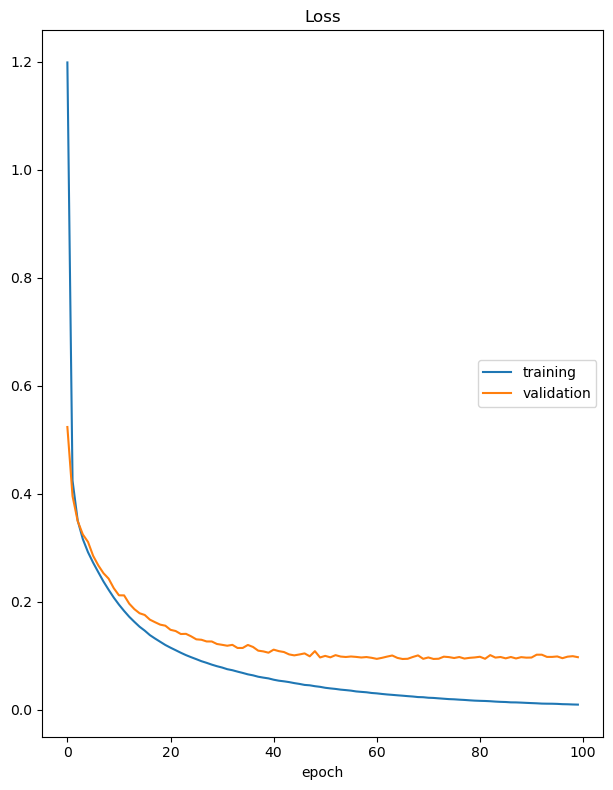

Epochs: 100%|█████████████████████████████████| 100/100 [21:15<00:00, 12.76s/it]


In [14]:
# Import necessary libraries
from livelossplot import PlotLosses  # Live plot for training loss visualization
from livelossplot.outputs import MatplotlibPlot  # Output type for livelossplot

# Number of epochs to train the model
n_epochs = 100  # Suggested training between 20-100 epochs
model_run_count = 0  # Counter for model runs (not used in the code)
model.train()  # Set the model in training mode
liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])  # Initialize live loss plot
logs = {}  # Dictionary to store training and validation loss

# Loop through each epoch with tqdm (progress bar)
for epoch in tqdm(
            range(n_epochs),
            desc="Epochs",
            total=n_epochs,
            leave=True,
            ncols=80,
        ):
    # Initialize training loss for the current epoch
    train_loss = 0.0
    
    ###################
    # Train the model #
    ###################
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: Compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output, target)
        
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Calculate average loss over an epoch
    average_train_loss = train_loss / len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()

        # Initialize validation loss for the current epoch
        valid_loss = 0.0
        for batch_idx, (data, target) in enumerate(val_loader):
            
            # 1. Forward pass: Compute predicted outputs by passing inputs to the model
            output = model(data)
            # 2. Calculate the loss
            loss = criterion(output, target)
            
            # Update running validation loss
            valid_loss += loss.item() * data.size(0)

        # Calculate average validation loss
        average_valid_loss = valid_loss / len(val_loader.dataset)
    
    # Update logs dictionary with training and validation loss
    logs['loss'] = average_train_loss
    logs['val_loss'] = average_valid_loss
    
    # Update and visualize live loss plot
    liveloss.update(logs)
    liveloss.send()

In [15]:
print(f"A: Total time model run in each epochs :{model_run_count}")
print(f"B: Total batches in train loader: {len(train_loader)}")
print(f"C: Total batches in train loader: {len(val_loader)}")
print(f"D: Total epochs: {n_epochs}")
print("A = (B + C) * D")
print("\n")

A: Total time model run in each epochs :93800
B: Total batches in train loader: 750
C: Total batches in train loader: 188
D: Total epochs: 100
A = (B + C) * D




---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [16]:
# Initialize variables to keep track of test loss, correct predictions per class, and total instances per class.
test_loss = 0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

# Set the model to evaluation mode, disabling certain operations like dropout.
model.eval()

# Iterate through the test_loader using tqdm for progress visualization.
for batch_idx, (data, target) in tqdm(
                        enumerate(test_loader),
                        desc="Testing",
                        total=len(test_loader),
                        leave=True,
                        ncols=80):

    # Forward pass: compute predicted outputs by passing input data through the model.
    output = model(data)

    # Calculate the loss between the model's output and the actual target labels.
    loss = criterion(output, target)
    # Accumulate the test loss, weighted by the number of data instances in the batch.
    test_loss += loss.item() * data.size(0)

    # Find the predicted class indices with the highest scores for each data instance.
    _, pred = torch.max(output, 1)

    # Iterate through each target label and update the class_correct and class_total counts.
    for i in range(target.shape[0]):
        label = target[i]
        # If the predicted class matches the target class, increment class_correct for that class.
        class_correct[label] += (1 if pred[i].item() == label else 0)
        # Increment class_total for the target class, regardless of prediction correctness.
        class_total[label] += 1

# Calculate the average test loss by dividing the accumulated test loss by the dataset size.
average_test_loss = test_loss / len(test_loader.dataset)
# Print the calculated average test loss.
print(f"Average test-loss: {average_test_loss}")

Testing: 100%|████████████████████████████████| 157/157 [00:02<00:00, 68.69it/s]

Average test-loss: 0.0842537120549241


In [17]:
# Loop through the range of values from 0 to 9
for i in range(10):
    # Check if there are any training examples for the current class
    if class_total[i] > 0:
        # Calculate the accuracy percentage for the current class and print the result
        print(f"Accuracy of {i}: {100 * class_correct[i] / class_total[i]} ({class_correct[i]}/{class_total[i]})")
    else:
        # If no training examples for the current class, print N/A
        print(f"Accuracy of {i}: N/A (no training examples)")

# Calculate and print the overall accuracy percentage across all classes
print(f"\nOverall Accuracy: {100 * sum(class_correct) / sum(class_total)}")

Accuracy of 0: 98.87755102040816 (969.0/980.0)
Accuracy of 1: 99.29515418502203 (1127.0/1135.0)
Accuracy of 2: 97.96511627906976 (1011.0/1032.0)
Accuracy of 3: 98.11881188118812 (991.0/1010.0)
Accuracy of 4: 97.14867617107943 (954.0/982.0)
Accuracy of 5: 96.97309417040358 (865.0/892.0)
Accuracy of 6: 97.7035490605428 (936.0/958.0)
Accuracy of 7: 96.78988326848248 (995.0/1028.0)
Accuracy of 8: 96.81724845995893 (943.0/974.0)
Accuracy of 9: 97.12586719524282 (980.0/1009.0)

Overall Accuracy: 97.71
